In [1]:
# Import what we need for the script.

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from EqW import *

In [2]:
# Create a function which generates a gaussian.

def gaussian(x, mu, sig, pwr):
    return pwr * (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

In [3]:
# Define a continuum fit function.

def region_around_line(w, flux, cont, pf = 0):
    '''cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
        array of wanvelenghts
    flux : np.ndarray of shape (N, len(w))
        array of flux values for different spectra in the series
    cont : list of lists
        wavelengths for continuum normalization [[low1,up1],[low2, up2]]
        that described two areas on both sides of the line
    '''
    #index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) |((w > cont[1][0]) & (w < cont[1][1]))
    #index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    fluxmean = np.mean(flux[:,np.where(indcont)])
    # make a flux array of shape
    # (nuber of spectra, number of pointsin indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynom of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont], pf)
        # devide the flux by the polynom and put the result in our
        # new flux array
        f[i,:] = flux[i,indrange]/np.polyval(linecoeff, w[indrange])
    if fluxmean < 0:
        f = -f
    return w[indrange], f

In [4]:
# Define error functions for the optimisation of the gaussian fit. Penalise fits far from the Ha line using regularisation (check if this is appropriate).

def error(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.sum(np.power(flux - fit, 2.)) + 0.01 * np.power(mu - 4861, 2.)

def error2(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.power(flux - fit, 2.)

In [5]:
# Import the scipy.optimize.minimize function

from scipy.optimize import minimize

In [6]:
# Import SpectRes package to rebin the gaussian into the spectrum wavelength bins whilst conserving flux.

from spectres import spectres

In [7]:
# Define a new error function using SpectRes for the optimisation.

def reerr(data, w, f, gauw):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    res_fluxes = spectres(w, gauw, gaussian(gauw, mu, sig, pwr))
    return np.sum(np.power(f - res_fluxes, 2.)) + 0.1 * np.power(mu - 4861, 2.)

In [8]:
def halinefit(file, rang, quiet = False, cfit = 0):
    
    flux = np.load(file)
    wavelength = np.load('wavelength.npy')
    
    wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), rang, pf = cfit)
    fha = np.reshape(fha, np.size(wha))
    
    if not quiet:
        plt.plot(wavelength, flux)
        plt.xlim((rang[0][0]-10,rang[1][1]+10))
        plt.ylim((-0.4e-17,0.2e-17))
        plt.show()
    
    x0 = np.array((4861, 10, -5))
    gauw = np.linspace(rang[0][0]-10, rang[1][1]+10, 1000)
    res = minimize(reerr, x0, args=(wha, fha, gauw), method='Nelder-Mead', tol=1e-6)
    
    if not quiet:
        plt.plot(wha, fha)
        plt.plot(gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    res_spec = spectres(wha, gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    if not quiet:
        plt.show()
    
    cont = fha - res_spec
    
    if not quiet:
        plt.plot(wha, cont)
        plt.show()
    
    ew = (np.sum(gaussian(gauw, res.x[0], res.x[1], res.x[2]))/res.x[2])*(gauw[1]-gauw[0])
    
    snr = np.abs(res.x[2]) / np.std(cont)
    
    if not quiet:
        print(res.x)
    
        print(np.std(cont))
    
        print(snr)
        
    quans = np.quantile(cont, [0.05, 0.95])
    
    return ew, snr, quans[0], quans[1]
    

In [9]:
rang = [[4800, 4840],[4875, 4900]]

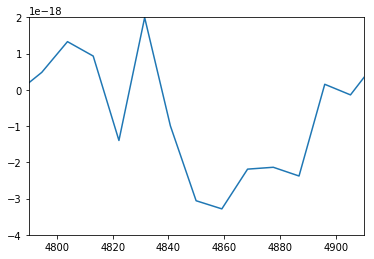

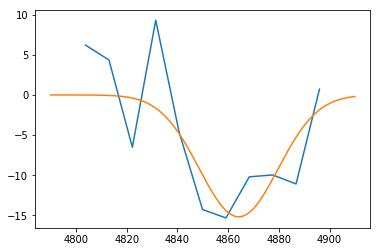

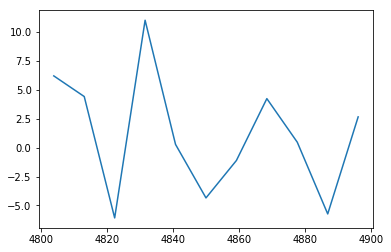

[4864.20307937   15.53083701  -15.17000641]
5.060924547484846
2.997477291510928


(38.86867465955264, 2.997477291510928, -5.90596482911175, 8.614707259672812)

In [10]:
halinefit('blap09_group1_mean_subtracted.npy', rang)

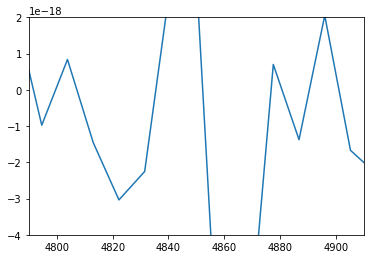

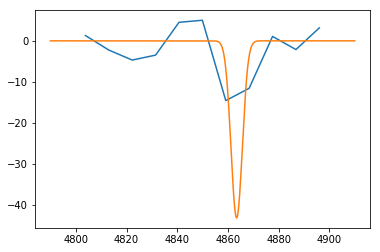

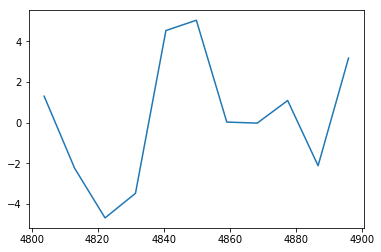

[ 4.86342128e+03  2.22624714e+00 -4.32523607e+01]
3.0430535629097246
14.213473342542027


(5.580374022873348, 14.213473342542027, -4.08827788168556, 4.7798906165315085)

In [11]:
halinefit('blap09_group2_mean_subtracted.npy', rang)

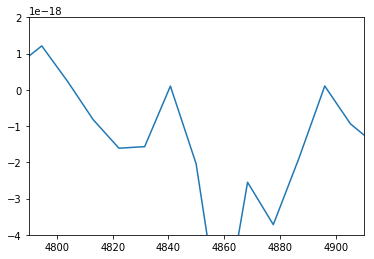

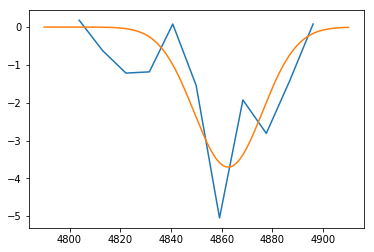

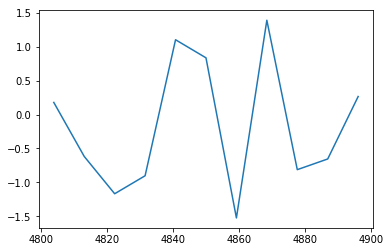

[ 4.86255222e+03  1.34895098e+01 -3.70241170e+00]
0.935255032884621
3.9587188214986115


(33.80594019198999, 3.9587188214986115, -1.346730085905444, 1.249695149076861)

In [12]:
halinefit('blap09_group3_mean_subtracted.npy', rang)

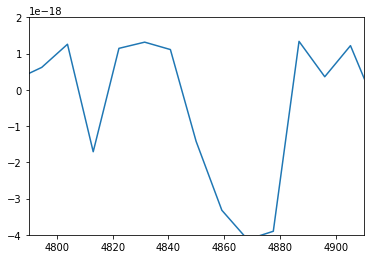

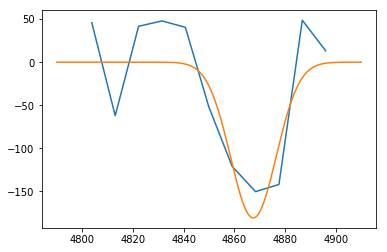

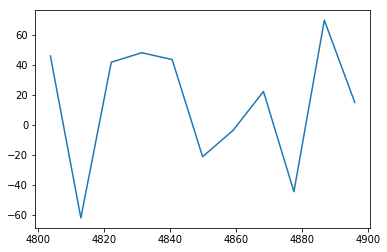

[4867.47197574    9.01527965 -180.81466663]
40.185307535457895
4.499521783358498


(22.59792875957101, 4.499521783358498, -53.398770860198866, 58.81377957072053)

In [13]:
halinefit('blap09_group4_mean_subtracted.npy', rang)

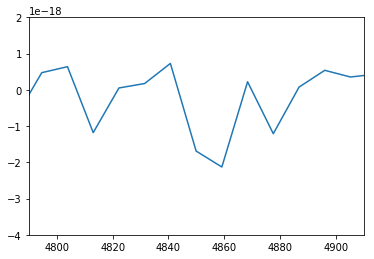

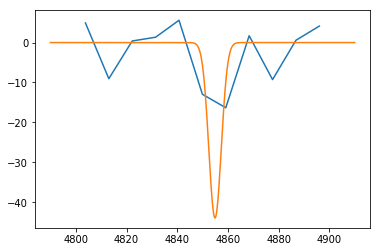

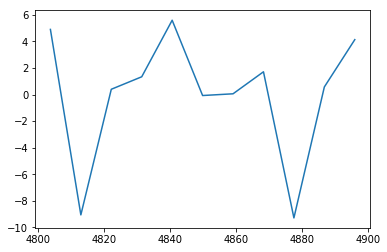

[ 4.85489710e+03  2.45130386e+00 -4.39516449e+01]
4.7280097163017265
9.296014076143992


(6.14450755335177, 9.296014076143992, -9.171912660448188, 5.248277511479975)

In [14]:
halinefit('blap14_group1_mean_subtracted.npy', rang)

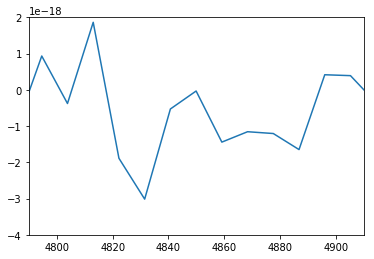

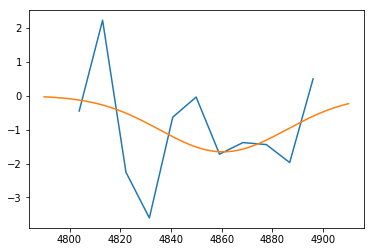

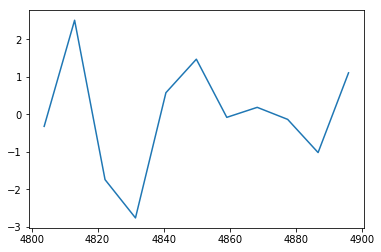

[ 4.86049120e+03  2.50000000e+01 -1.65453397e+00]
1.408412619635604
1.1747508851512543


(61.031185300149104,
 1.1747508851512543,
 -2.2501114775210573,
 1.9860981442442394)

In [15]:
halinefit('blap14_group3_mean_subtracted.npy', rang)

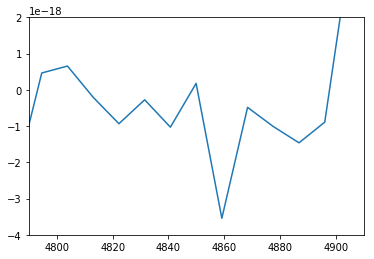

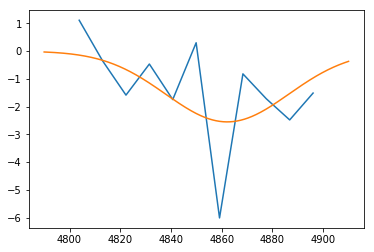

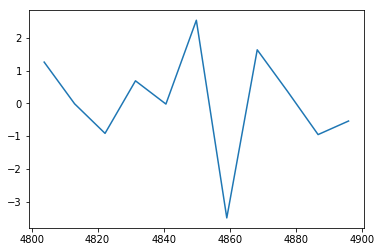

[ 4.86216682e+03  2.43260472e+01 -2.55141581e+00]
1.5239349380335652
1.6742288293599528


(59.392136717431114,
 1.6742288293599528,
 -2.2242745235492456,
 2.087097927360247)

In [16]:
halinefit('blap14_group4_mean_subtracted.npy', rang)